In [1]:
import base64
from datetime import datetime
import json
import os

import contextily as ctx
from FH_Hydrosat import FH_Hydrosat
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj.crs import CRS
from pystac_client import Client
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import Window
import rasterio
import rioxarray
from shapely.geometry import mapping
import seaborn as sns
from shapely.geometry import box, Point, Polygon
import xarray as xr

In [2]:
# Insitu point locations
insitu_met_points = {
    'Corn': [-121.5351, 38.1091],
    'Alfalfa': [-121.4993, 38.0992]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

aoi_bbox = {
    'Alfalfa': [-121.504670, 38.100631, -121.5355, 38.1091],
    'Corn': [-121.5027, 38.0986, -121.5003, 38.1000]
}

aoi_coordinates = {
    'Alfalfa': [
        (-121.504670, 38.100631),
        (-121.501246, 38.101757),
        (-121.498513, 38.098168),
        (-121.501920, 38.097003)
    ]
}

In [3]:
# Define function to process Ameriflux data
def read_ameriflux(data_path):
    df = pd.read_csv(data_path, header=2, na_values=[-9999])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

In [4]:
# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')
bi1_data_path = os.path.join(data_path, 
                             'AMF_US-Bi1_BASE-BADM_8-5',
                             'AMF_US-Bi1_BASE_HH_8-5.csv')
# Explore bi1 data
bi1_df = read_ameriflux(bi1_data_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')

Data range from 2016-08-13 00:00:00 to 2022-05-26 23:30:00


In [5]:
# Authenticate and access catalog
with open(os.path.join('../secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [6]:
geom = {'type': 'Point', 'coordinates': crop_center_points['Alfalfa']}
start_date = "2022-04-30T00:00:00Z"
end_date = "2022-08-31T00:00:00Z"
pt = Point(geom['coordinates'])
aoi = aoi_coordinates['Alfalfa']
poly = Polygon(aoi)
poly_gdf = gpd.GeoDataFrame({'geometry':[poly]}, crs=CRS.from_epsg(4326))
poly_gdf = poly_gdf.to_crs(crs = CRS.from_epsg(32610))
collections_dict = {
    'collection': ['prepped_inputs_s2', 
                   'prepped_inputs_landsat', 
                   'prepped_inputs_mcd43a4', 
                   'prepped_inputs_mod21a1d',
                   'pydms_sharpened_modis',
                   'pydms_sharpened_landsat',
                   'starfm_predictions_modis_landsat'],
    'asset': ['surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'lst',
              'lst',
              'lst'],
    'tolerance': [40, 60, 1000, 2000, 1000, 40, 40],
    'red_band': [2, 2, 0, 0, 0,  0,  0],
    'nir_band': [6, 6, 1,  1,  0,  0, 0]
}
collections_df = pd.DataFrame(collections_dict)
collections_df

,collection,asset,tolerance,red_band,nir_band
0,prepped_inputs_s2,surface_reflectance,40,2,6
1,prepped_inputs_landsat,surface_reflectance,60,2,6
2,prepped_inputs_mcd43a4,surface_reflectance,1000,0,1
3,prepped_inputs_mod21a1d,surface_reflectance,2000,0,1
4,pydms_sharpened_modis,lst,1000,0,0
5,pydms_sharpened_landsat,lst,40,0,0
6,starfm_predictions_modis_landsat,lst,40,0,0


In [7]:
collection = 'starfm_predictions_modis_landsat'
search = catalog.search(
    collections=collection,
    intersects=geom,
    datetime=[start_date, end_date],
    max_items=500
)

s2_items = search.get_all_items()
print(f'number of source {collection} items: {len(s2_items)}')

number of source starfm_predictions_modis_landsat items: 93


In [8]:
itemjson = s2_items.to_dict()
filepath = itemjson["features"][1]["assets"]["lst"]["href"]

with rasterio.open(filepath) as src:
    out_image, out_transform = rasterio.mask.mask(src, poly_gdf.geometry.apply(mapping), crop=True)
    out_meta = src.meta

# Update metadata after mask
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Assign coordinate values from out_meta
coords = {
    "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
    "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"])
}

# Create a new DataArray with updated coordinates
data_array = xr.DataArray(
    out_image.squeeze(),
    coords=coords,
    dims=("y", "x"),  # Update dimensions as per your data shape
)

# Set the CRS (Coordinate Reference System) for the DataArray
data_array.rio.set_crs(out_meta["crs"])

data_array

<xarray.DataArray (y: 28, x: 28)>
array([[      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan, 310.06506, 310.64764,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan, 310.63486,
        311.7641 , 312.37616, 311.9647 , 311.82056, 312.1017 ,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan, 311.44012, 311.58713, 311.7611 ,
        312.15414, 312.45715, 312.17798, 311.77005, 312.0033 ,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
...
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan, 312.332  ,
        312.23987, 312.25696, 312.47885, 312.58353, 312.1003 , 311.89954,
        309.0124 ,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
        312.10678, 312.28888, 312.29123, 312.21222,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
        312.32425, 310.8136 ,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan]], dtype=float32)
Coordinates:
  * x        (x) float64 6.311e+05 6.311e+05 6.311e+05 ... 6.316e+05 6.316e+05
  * y        (y) float64 4.218e+06 4.218e+06 4.218e+06 ... 4.218e+06 4.218e+06

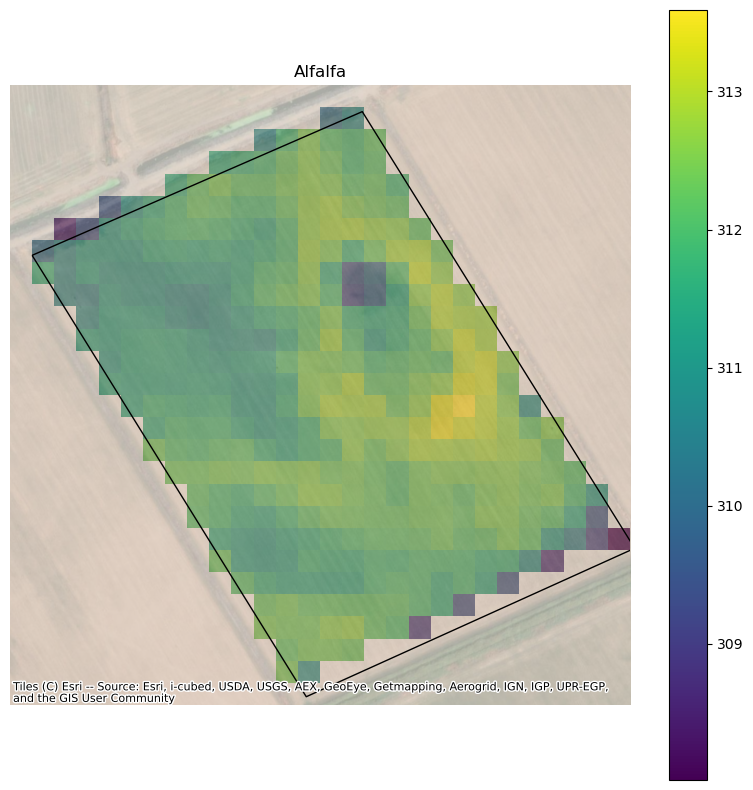

In [9]:
# Plot raster
fig, ax = plt.subplots(figsize=(10, 10))

data_array.plot.imshow(ax=ax, add_colorbar=True)
poly_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
ctx.add_basemap(ax, crs=poly_gdf.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

# Format axes
ax.set_title('Alfalfa')
ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
ax.axes.set_aspect('equal')
ax.set_axis_off()


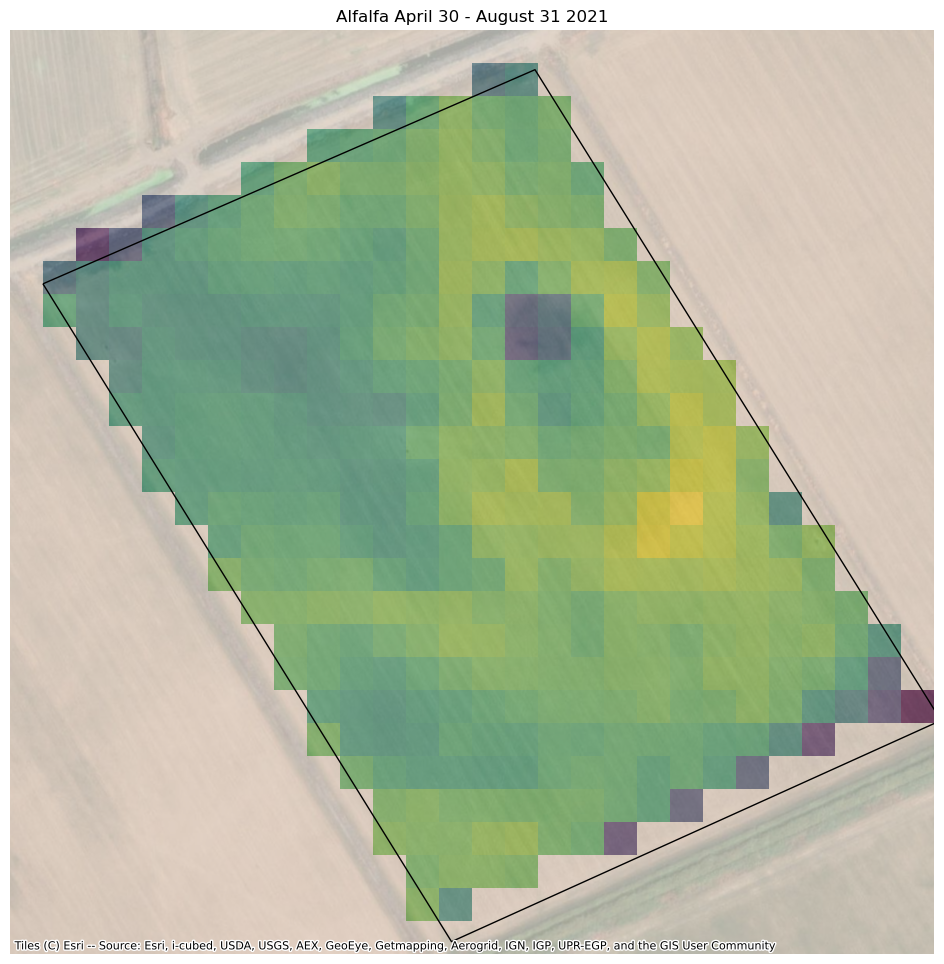

In [10]:
# Open the file with Rasterio
Session = rasterio.Env()

with Session:
    with rasterio.open(filepath) as src:
        out_image, out_transform = rasterio.mask.mask(src, poly_gdf.geometry.apply(mapping), crop=True)
        out_meta = src.meta

        # Update metadata after mask
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

        # Assign coordinate values from out_meta
        coords = {
            "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
            "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"])
        }

        # Create a new DataArray with updated coordinates
        data_array = xr.DataArray(
            out_image.squeeze(),
            coords=coords,
            dims=("y", "x"),  # Update dimensions as per your data shape
        )

        # Set the CRS (Coordinate Reference System) for the DataArray
        data_array.rio.set_crs(out_meta["crs"])
        fig, ax = plt.subplots(1, 1, figsize=(12,12))
        im = data_array.plot.imshow(ax=ax, add_colorbar=False, animated=True)
        poly_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
        ctx.add_basemap(ax, crs=poly_gdf.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

        # Format axes
        ax.set_title('Alfalfa April 30 - August 31 2022')
        ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
        ax.axes.set_aspect('equal')
        ax.set_axis_off()

In [11]:
# import IPython.display
#Sort the results in time
features = itemjson['features']
# IPython.display.JSON(features)
assetlist = {}
for f in features:
    assetlist.update( {f["properties"]["datetime"] : f["assets"]["lst"]["href"]})  


In [12]:
sorted(assetlist.keys())

['2022-04-30T00:00:00Z',
 '2022-05-01T00:00:00Z',
 '2022-05-02T00:00:00Z',
 '2022-05-05T00:00:00Z',
 '2022-05-06T00:00:00Z',
 '2022-05-07T00:00:00Z',
 '2022-05-08T00:00:00Z',
 '2022-05-09T00:00:00Z',
 '2022-05-10T00:00:00Z',
 '2022-05-13T00:00:00Z',
 '2022-05-14T00:00:00Z',
 '2022-05-15T00:00:00Z',
 '2022-05-16T00:00:00Z',
 '2022-05-17T00:00:00Z',
 '2022-05-18T00:00:00Z',
 '2022-05-21T00:00:00Z',
 '2022-05-22T00:00:00Z',
 '2022-05-23T00:00:00Z',
 '2022-05-24T00:00:00Z',
 '2022-05-25T00:00:00Z',
 '2022-05-26T00:00:00Z',
 '2022-05-29T00:00:00Z',
 '2022-05-30T00:00:00Z',
 '2022-05-31T00:00:00Z',
 '2022-06-01T00:00:00Z',
 '2022-06-02T00:00:00Z',
 '2022-06-03T00:00:00Z',
 '2022-06-06T00:00:00Z',
 '2022-06-07T00:00:00Z',
 '2022-06-08T00:00:00Z',
 '2022-06-09T00:00:00Z',
 '2022-06-10T00:00:00Z',
 '2022-06-11T00:00:00Z',
 '2022-06-14T00:00:00Z',
 '2022-06-15T00:00:00Z',
 '2022-06-16T00:00:00Z',
 '2022-06-17T00:00:00Z',
 '2022-06-18T00:00:00Z',
 '2022-06-19T00:00:00Z',
 '2022-06-22T00:00:00Z',


In [21]:
%matplotlib notebook
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.animation as animation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ctx.add_basemap(ax, crs=poly_gdf.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

# Open the file with Rasterio
Session = rasterio.Env(
            GDAL_DISABLE_READDIR_ON_OPEN='YES',
            CPL_VSIL_CURL_USE_HEAD='NO',
            )
ims=[]
for key in sorted(assetlist.keys()):   
    with Session:
        filepath = assetlist[key]
        timestamp = key
        with rasterio.open(filepath) as src:
            out_image, out_transform = rasterio.mask.mask(src, poly_gdf.geometry.apply(mapping), crop=True)
            out_meta = src.meta

            # Update metadata after mask
            out_meta.update({"driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform})

            # Assign coordinate values from out_meta
            coords = {
                "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
                "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"])
            }

            # Create a new DataArray with updated coordinates
            data_array = xr.DataArray(
                out_image.squeeze(),
                coords=coords,
                dims=("y", "x"),  # Update dimensions as per your data shape
            )

            # Set the CRS (Coordinate Reference System) for the DataArray
            data_array.rio.set_crs(out_meta["crs"])

            
            im = data_array.plot.imshow(ax=ax, add_colorbar=False, animated=True)
            poly_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
            

            # Format axes
            ax.set_title('Alfalfa April 30 - August 31 2022')
            ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
            ax.axes.set_aspect('equal')
            ax.set_axis_off()
            
            ims.append([im])
            
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500)

ani.save('anim.gif', writer="imagemagick")

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
assets = s2_items[0].to_dict()['assets'].keys()
res_full = FH_Hydrosat(s2_items, asset='surface_reflectance')
res_dt = res_full.datetime

In [ ]:
import folium

m = folium.Map()

folium.Marker(location = [crop_center_points['Alfalfa'][1], crop_center_points['Alfalfa'][0]]).add_to(m)

# Add polygons to the map
for idx, row in poly_gdf.to_crs(4326).iterrows():
    geojson = row.geometry.__geo_interface__
    folium.GeoJson(geojson).add_to(m)

m.fit_bounds(m.get_bounds())
m